In [96]:
from __future__ import print_function
import os
import numpy as np

from scipy.stats import norm

from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import metrics, losses
from keras.datasets import mnist

class VAE:
    
    def __init__(self, batch_size=100, original_dim =512*3, latent_dim = 10, epochs=50, root="IsingMC/", epsilon=0.5):
        self.batch_size = batch_size
        self.original_dim = original_dim
        self.latent_dim = latent_dim
        self.intermediate_dim = 512*3
        self.epochs = epochs
        self.epsilon_std = epsilon
    
    def sampling(self, args):
        ''' Sampling from the latent variables using the means and log-variances'''
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], self.latent_dim), mean=0.,
                                  stddev=self.epsilon_std)
        return z_mean + K.exp(z_log_var / 2) * epsilon

    def build(self):
        """ This class method constructs the VAE model
        """
        original_dim = self.original_dim
        latent_dim = self.latent_dim
        intermediate_dim = self.intermediate_dim
        
        # encoder
        self.x = Input(shape=(original_dim,))
        h1 = Dense(intermediate_dim, activation='relu')(self.x)
        h2 = Dense(intermediate_dim, activation='relu')(h1)
        self.z_mean = Dense(latent_dim)(h2)
        self.z_log_var = Dense(latent_dim)(h2)
        
        # note that "output_shape" isn't necessary with the TensorFlow backend
        z = Lambda(self.sampling, output_shape=(latent_dim,))([self.z_mean, self.z_log_var])
        
        # we instantiate these layers separately so as to reuse them later
        decoder_h1 = Dense(intermediate_dim, activation='relu')
        decoder_h2 = Dense(intermediate_dim, activation='relu')
        decoder_mean = Dense(original_dim, activation='sigmoid')
        h_decoded1 = decoder_h1(z)
        h_decoded2 = decoder_h2(h_decoded1)
        x_decoded_mean = decoder_mean(h_decoded2)
        
        #decoder
        decoder_input = Input(shape=(latent_dim,))
        _h_decoded1 = decoder_h1(decoder_input)
        _h_decoded2 = decoder_h2(_h_decoded1)
        _x_decoded_mean = decoder_mean(_h_decoded2)
        
        self.generator = Model(decoder_input, _x_decoded_mean)
        
        # end-to-end VAE model
        self.vae = Model(self.x, x_decoded_mean)
        
        # encoder, from inputs to latent space
        self.encoder = Model(self.x, self.z_mean)
        
        print(K.int_shape(x_decoded_mean),K.int_shape(self.z_mean),K.int_shape(self.x))
        
        # decoder
        #self.decoder = Model(decoder_input, _x_decoded_mean)
        
        # Compute VAE loss
        self.vae.compile(optimizer='adam', loss=self.vae_loss)#, metrics=["accuracy"])
        
        # Prints a summary of the architecture used
        self.vae.summary()
        
    def vae_loss(self, x, x_decoded_mean):
            rms_loss = losses.mean_squared_error(x, x_decoded_mean)
            #xent_loss = losses.binary_cross_entropy(x, x_decoded_mean)
            kl_loss = - 0.5 * K.mean(1 + self.z_log_var - K.square(self.z_mean) - K.exp(self.z_log_var), axis=-1)
            return rms_loss + kl_loss
        
    def train(self, x_train, x_test):
        from sklearn.preprocessing import minmax_scale, normalize
        
        x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:]))) # flatten each sample out 
        x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
        #x_train = normalize(x_train)
        #x_test = normalize(x_train)
        x_train = minmax_scale(x_train) # this step is required in order to use cross-entropy loss for reconstruction
        x_test = minmax_scale(x_train) # scaling features in 0,1 interval
        
        
        self.vae.fit(x_train, x_train,
                shuffle=True,
                epochs=self.epochs,
                batch_size=self.batch_size,
                validation_data=(x_test, x_test)
                )

        # build a model to project inputs on the latent space
        #encoder = Model(self.x, self.z_mean)
        
    def predict_latent(self, xnew):
        # build a model to project inputs on the latent space
        return self.encoder.predict(xnew)
    
    def generate_decoding(self, znew):
        # Generate new fantasy particles 
        return self.generator.predict(znew)

## Load the dataset 

In [40]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

X=np.loadtxt('X.csv',delimiter=',')
Y=np.loadtxt('Y.csv',delimiter=',')

[-0.74518908  4.05989612  0.29156606] [0.37549179 0.05996819 0.40601398]


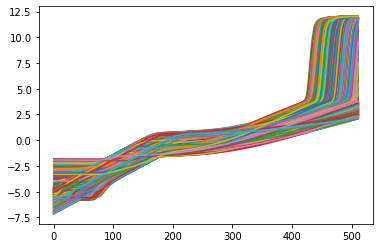

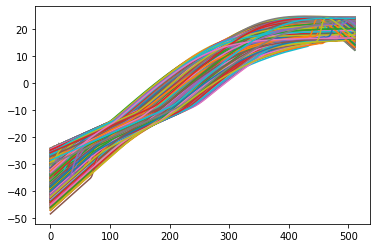

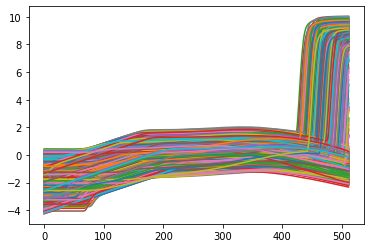

In [41]:
X=np.reshape(X,(-1,512,3))

x_mean=np.mean(np.mean(X,axis=0),axis=0)
x_std=np.std(np.std(X,axis=0),axis=0)
print(x_mean,x_std)
for i in range(3):
    X[:,:,i]=(X[:,:,i]-x_mean[i])/x_std[i]

for i in range(3):
    plt.plot(np.transpose(X[:,:,i]))
    plt.show()
    
X=np.reshape(X,(-1,512*3))

(800, 1536) (800, 3) (200, 1536) (200, 3)


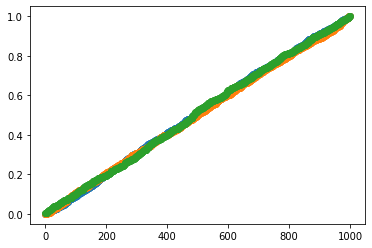

In [43]:
m=1

Y[:,:m]=np.log10(Y[:,:m])#sigma
Y[:,m:2*m]=np.log10(Y[:,m:2*m])+1#E_th
Y[:,2*m:]=np.log10(Y[:,2*m:])/2#slope

'''
Y[:,:m]=np.log10(Y[:,:m])/4+0.5
Y[:,m:2*m]/=2
Y[:,2*m:3*m]=np.log10(Y[:,2*m:3*m])/2
Y[:,3*m:]=np.log10(np.abs(Y[:,3*m:]))/2
'''
plt.plot(np.sort(Y,axis=0),'o')

xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.2)

print(np.shape(xtrain),np.shape(ytrain),np.shape(xtest),np.shape(ytest))

## Construct and train the variational autoencoder model

In [98]:
model = VAE(epochs=50, latent_dim=3, epsilon=0.2) # Choose model parameters
model.build() # Construct VAE model using Keras
model.train(xtrain, xtest) # Trains VAE model based on custom loss function

(None, 1536) (None, 3) (None, 1536)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           (None, 1536)         0                                            
__________________________________________________________________________________________________
dense_63 (Dense)                (None, 1536)         2360832     input_21[0][0]                   
__________________________________________________________________________________________________
dense_64 (Dense)                (None, 1536)         2360832     dense_63[0][0]                   
__________________________________________________________________________________________________
dense_65 (Dense)                (None, 3)            4611        dense_64[0][0]                   
_________________________________________________________________________

## Encoding samples to latent space:

We predict the latent variable coordinates for the test set:

In [99]:
np.shape(xtrain)

(800, 1536)

In [100]:
zpred = model.predict_latent(xtrain)
print(zpred.shape)

(800, 3)


<IPython.core.display.Javascript object>


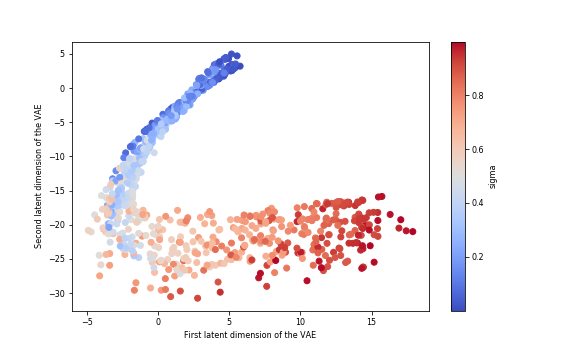

<IPython.core.display.Javascript object>


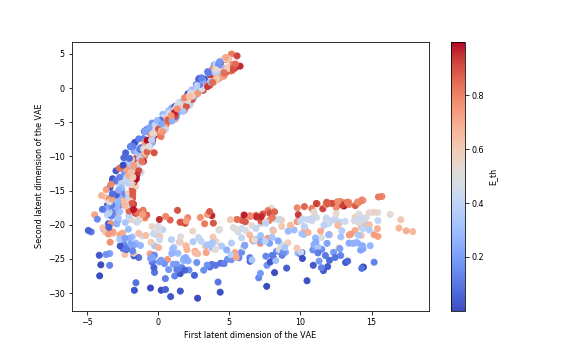

<IPython.core.display.Javascript object>


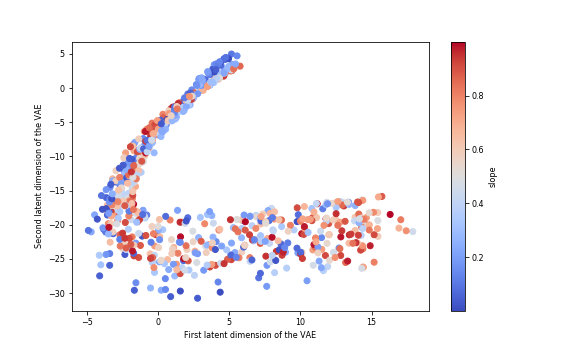

'    \nfor i in range(4):\n    plt.rc(\'font\',**{\'size\':8})\n    fig = plt.figure()\n    ax = fig.add_subplot(111, projection=\'3d\')\n    #fig, ax = plt.subplots(1,figsize=golden_size(8))\n    sc = ax.scatter(zpred[:,0], zpred[:,1], zpred[:,2], c=ytrain[:,i], cmap="coolwarm")\n    #ax.set_xlabel(\'First latent dimension of the VAE\')\n    #ax.set_ylabel(\'Second latent dimension of the VAE\')\n    #plt.colorbar(sc, label=\'sigma_m\')\n    #plt.savefig(\'Sigma_m.png\')\n    plt.show()\n'

In [104]:
# To make plots pretty
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

golden_size = lambda width: (width, 2. * width / (1 + np.sqrt(5)))

label=['sigma','E_th','slope']
for i in range(3):
    plt.rc('font',**{'size':8})
    #fig = plt.figure()
    #ax = fig.add_subplot(111, projection='3d')
    fig, ax = plt.subplots(1,figsize=golden_size(8))
    sc = ax.scatter(zpred[:,0], zpred[:,1], c=ytrain[:,i], cmap="coolwarm")
    ax.set_xlabel('First latent dimension of the VAE')
    ax.set_ylabel('Second latent dimension of the VAE')
    plt.colorbar(sc, label=label[i])
    plt.savefig(label[i]+'.png')
    plt.draw()
'''    
for i in range(4):
    plt.rc('font',**{'size':8})
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    #fig, ax = plt.subplots(1,figsize=golden_size(8))
    sc = ax.scatter(zpred[:,0], zpred[:,1], zpred[:,2], c=ytrain[:,i], cmap="coolwarm")
    #ax.set_xlabel('First latent dimension of the VAE')
    #ax.set_ylabel('Second latent dimension of the VAE')
    #plt.colorbar(sc, label='sigma_m')
    #plt.savefig('Sigma_m.png')
    plt.show()
'''

<IPython.core.display.Javascript object>


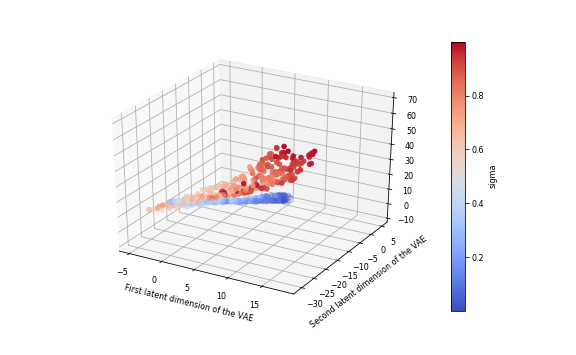

/home/vinit/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/mpl_toolkits/mplot3d/art3d.py:794: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if zdir == 'x':
/home/vinit/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/mpl_toolkits/mplot3d/art3d.py:796: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif zdir == 'y':


<IPython.core.display.Javascript object>


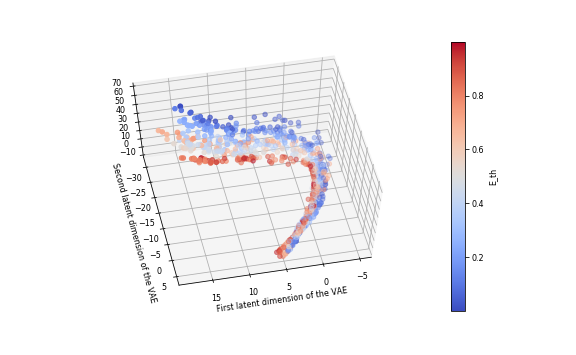

<IPython.core.display.Javascript object>


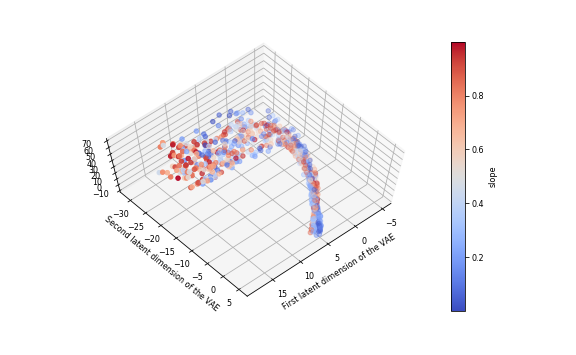

In [102]:
# To make plots pretty
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
%matplotlib notebook

golden_size = lambda width: (width, 2. * width / (1 + np.sqrt(5)))

label=['sigma','E_th','slope']
for i in range(3):
    plt.rc('font',**{'size':8})
    #fig = plt.figure()
    #ax = fig.add_subplot(111, projection='3d')
    fig=plt.figure(figsize=golden_size(8))
    ax = fig.add_subplot(111, projection='3d')
    cmhot = plt.get_cmap("hot")
    
    ax.scatter(zpred[:,0], zpred[:,1], zpred[:,2], ytrain[:,i], c=ytrain[:,i], cmap="coolwarm")
    ax.set_xlabel('First latent dimension of the VAE')
    ax.set_ylabel('Second latent dimension of the VAE')
    plt.colorbar(sc, label=label[i])
    plt.draw()
    #plt.savefig('Sigma_m.png')